In [135]:
library(dlnm)
library(mgcv)
library(data.table)
library(plotly)
library(ggplot2)
library(splines)
library(parallel)
library(doParallel)
library(foreach)
library(coda)
library(lubridate)
library(xts)
library(timetk)
library(forecast)
library(gridExtra)
library(tidyr)
library(dplyr)
library(Hmisc)
library(xtable)
library(MuMIn)
library(dlnm) ; library(splines) ; library(MASS) ; library(tsModel)

$fun
[1] "ns"

$knots
 10%  75%  90% 
12.9 41.0 52.0 

$Bound
[1]  2 83



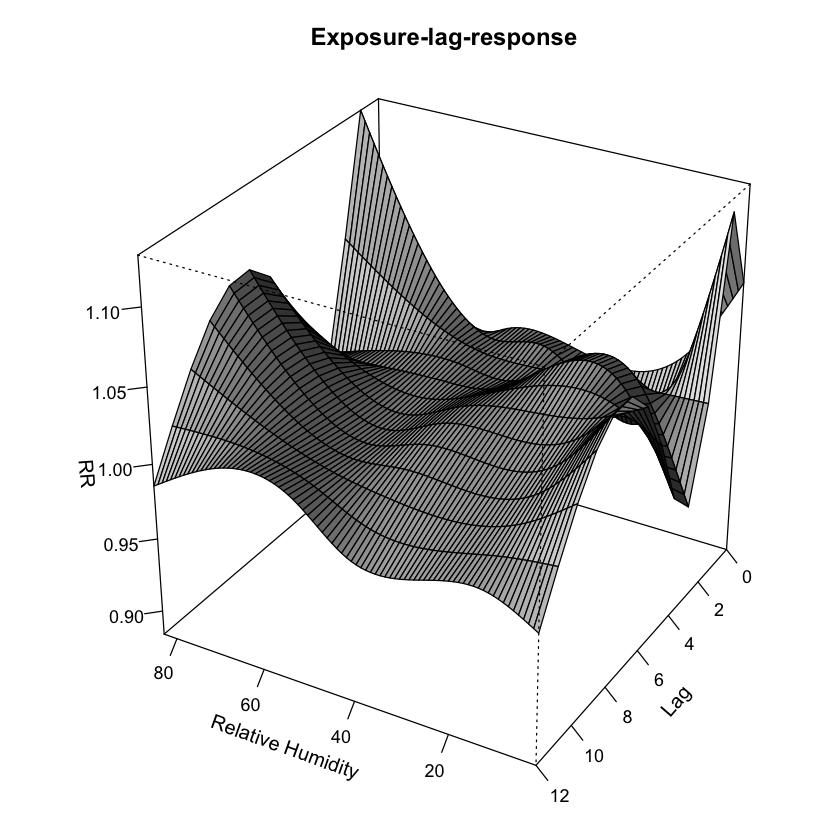

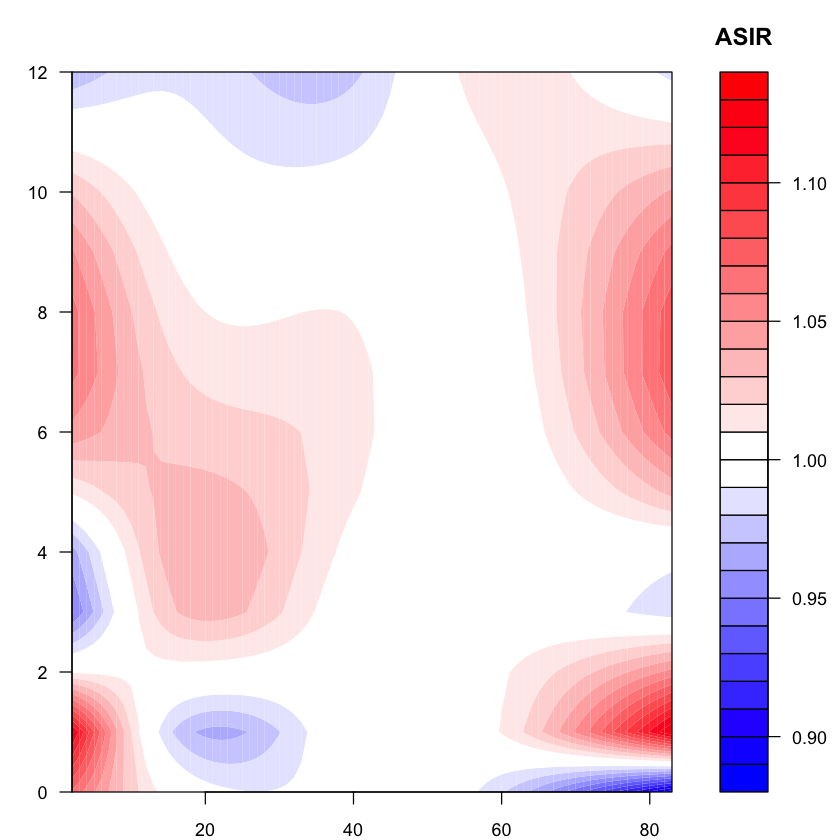

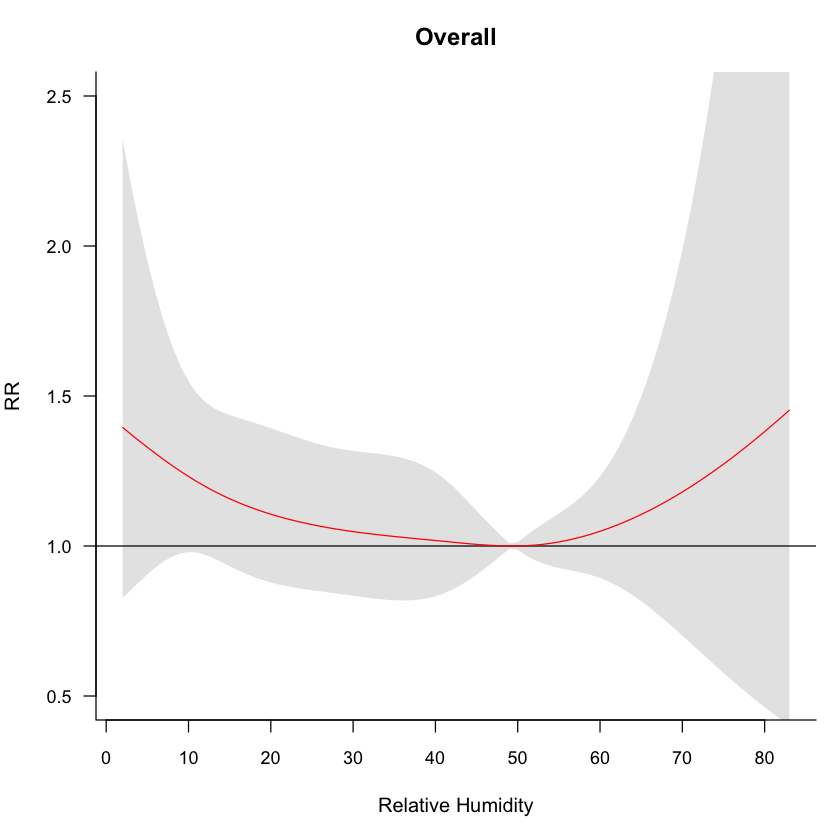


Call:
glm(formula = asir ~ cb + dow + is_holiday + o301 + PM10 + ns(date, 
    df = round(8 * length(date)/365.25)), family = quasipoisson, 
    data = data)

Coefficients:
                                                  Estimate Std. Error t value
(Intercept)                                     -0.3438036  0.3628768  -0.947
cbv1.l1                                         -0.1124665  0.1039061  -1.082
cbv1.l2                                          0.0952225  0.0741850   1.284
cbv1.l3                                         -0.0311755  0.0702074  -0.444
cbv1.l4                                         -0.1383351  0.0743654  -1.860
cbv1.l5                                          0.0388684  0.0601257   0.646
cbv2.l1                                         -0.0850349  0.1172323  -0.725
cbv2.l2                                          0.0675069  0.0875488   0.771
cbv2.l3                                         -0.1183781  0.0848262  -1.396
cbv2.l4                                       

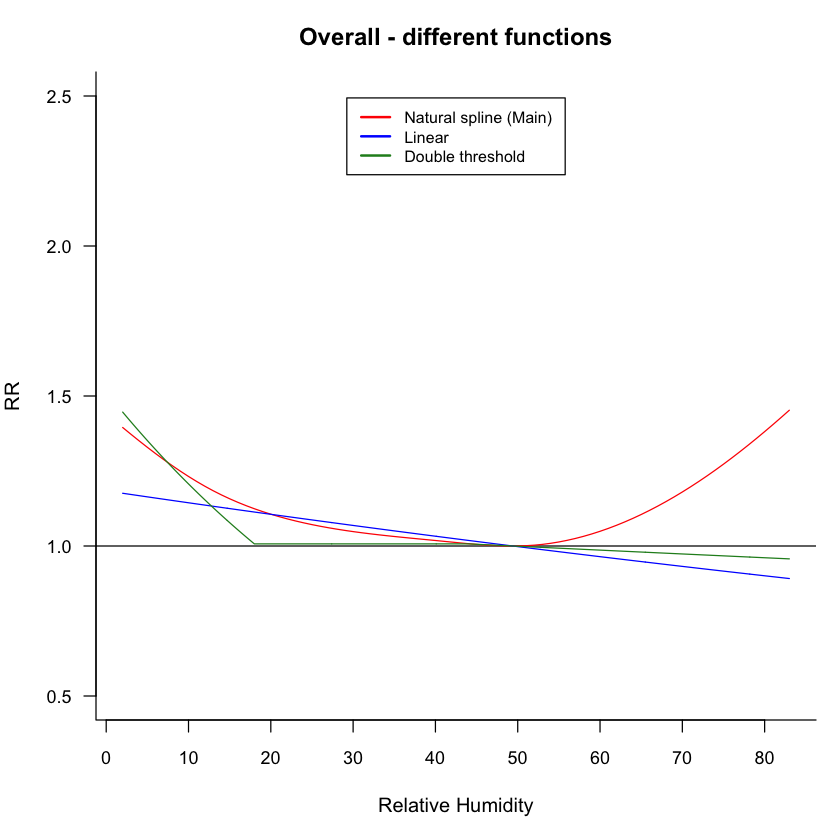

In [136]:
################################################################################
# READ DATA
################################################################################
data <- read.csv("modelling_data/data.csv")

data <- data[c('at_code','date','events','min_temp','min_hum','max_temp','asir','is_holiday','dow','day','month','year','doy','season','mean_PM10','mean_O3')]
data = data[(data$at_code=="AT01"),]

data$date <- as.Date(data$date)
# Create lagged variables using dplyr's lag function
data <- data %>%
  arrange(date) %>%
  mutate(
    o301 = lag(mean_O3, 1),
    PM10 = lag(mean_PM10, 1)
  )


# Function to categorize each month into a season
categorize_season <- function(month) {
  if (month %in% c(5, 6, 7, 8, 9, 10)) {
    return("Summer")
  } else {
    return("Winter")
  }
}

# Add a new column "season" to the environmeAMIet based on the month
data$season <- sapply(data$month, categorize_season)

data = data[(data$season=="Winter"),]
################################################################################
# ESTIMATION OF THE EXPOSURE-RESPONSE ASSOCIATIONS
################################################################################
argvar <- list(fun="ns", knots = quantile(data$min_hum,c(10,75,90)/100, na.rm=T),
  Bound=range(data$min_hum,na.rm=T))
print(argvar)
argvar1 <- list(fun="lin")
argvar2 <- list(fun="thr", thr.value=quantile(data$min_hum,c(20,80)/100, na.rm=T),
  side="d")

################################################################################
# - SPECIFICATION PARAMETERS OF THE LAG-ASSOCIATION DIMENSION OF THE CROSS-BASIS
################################################################################
# Definition of the maximum lag, that is, 12 days
maxlag <- 12
# arglag: main model, it fits a cubic natural spline with three internal knots 
#   equally-spaced in the log-scale.
arglag <- list(fun="ns",knots=logknots(maxlag,nk=3))

################################################################################
# - CREATE CROSSBASIS OBJECTS
################################################################################
cb <- crossbasis(data$min_hum,maxlag,argvar,arglag)  
cb1 <- crossbasis(data$min_hum,maxlag,argvar1,arglag)   
cb2 <- crossbasis(data$min_hum,maxlag,argvar2,arglag)

################################################################################
# FIT THE MODEL
################################################################################

m <- glm(asir ~ cb + dow + is_holiday + o301 + PM10 + ns(date,df=round(8*length(date)/365.25)), 
  data=data, family=quasipoisson)

m1 <- glm(asir ~ cb1 + dow + is_holiday + ns(date,df=round(8*length(date)/365.25)), 
  data=data, family=quasipoisson)
m2 <- glm(asir ~ cb2 + dow + is_holiday + ns(date,df=round(8*length(date)/365.25)), 
  data=data, family=quasipoisson)

################################################################################
# GET PREDICTIONS & PLOT
################################################################################
# - DEFINE PROVISIONAL CENTERING POINT TO HAVE THE INITIAL PREDICTION
varcen <- 21
# - ESTIMATE MMT FROM THE PREDICTED EXPOSURE-RESPONSE ASSOCIATION 
cp <- crosspred(cb,m,cen=varcen,by=0.1)
cen <- cp$predvar[which.min(cp$allRRfit)] 

# - RE-CENTER & GET PREDICTIONS FOR EACH MODEL CENTERING ON THE MMT 
pred <- crosspred(cb, m, cen=cen, by=1)   

pred1 <- crosspred(cb1, m1, cen=cen, by=0.1)   
pred2 <- crosspred(cb2, m2, cen=cen, by=0.1)   

################################################################################
# PLOTS
################################################################################
xlab <- "Relative Humidity"

# PLOT - 3D
par(mar=c(2,3,3,1),mgp=c(3,1,0),las=1,cex.axis=0.9,cex.lab=1)
plot(pred,"3d",ltheta=150,xlab="Relative Humidity",ylab="Lag",zlab="RR", 
  col=gray(0.9), main="Exposure-lag-response")

plot(pred, "contour", key.title=title("ASIR"), plot.title=title( xlab ="Min Hum", ylab = "Lag (days)", cex.lab=1.1, cex.axis=1.1))
#plot(pred1, "contour", key.title=title("ASIR"), plot.title=title(xlab ="Min Hum", ylab = "Lag (days)", cex.lab=1.1, cex.axis=1.1))
#plot(pred2, "contour", key.title=title("ASIR"), plot.title=title(xlab ="Min Hum", ylab = "Lag (days)", cex.lab=1.1, cex.axis=1.1))

# OVERALL
# The plots show the cumulative exposure-response association, in terms of 
#    relative risks (RR) and centered in the MMT, across the 14 days of lag.
par(mar=c(5,4,3,1),mgp=c(3,1,0),las=1,cex.axis=0.9,cex.lab=1)
plot(pred,"overall",col="red",ylim=c(0.5,2.5),axes=T,lab=c(6,5,7),xlab=xlab,
  ylab="RR",main="Overall")

# OVERALL DIFFERENT FUNCTIONS
# See the different shapes of the exposure-response association using the
#   three functions (non-linear, linear, double threshold).
par(mar=c(5,4,3,1),mgp=c(3,1,0),las=1,cex.axis=0.9,cex.lab=1)
plot(pred,"overall",col="red",ylim=c(0.5,2.5),axes=T,lab=c(6,5,7),xlab=xlab,
  ylab="RR",ci="n",main="Overall - different functions")
lines(pred1, col="blue")
lines(pred2, col="forestgreen")

legend("top",c("Natural spline (Main)","Linear","Double threshold")
  ,xpd = TRUE,col=c("red","blue","forestgreen"),lwd=2,bg="white"
  ,cex=0.8,ncol=1,inset=0.04)

summary(m)

# CREATE ALL CROSSBASIS FUNCTIONS!


Call:
glm(formula = asir ~ cb_PM10 + cb_min_hum + cb_O3 + cb_max_temp + 
    is_holiday + dow + ns(day, df = 4) + ns(month, df = 6) + 
    ns(year, df = 8), family = quasipoisson, data = data)

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         0.1932213  0.2213602   0.873 0.382792    
cb_PM10v1.l1       -0.0502756  0.0725150  -0.693 0.488163    
cb_PM10v1.l2        0.0102443  0.0401803   0.255 0.798772    
cb_PM10v1.l3       -0.0091625  0.0549845  -0.167 0.867666    
cb_PM10v2.l1       -0.0217261  0.1592943  -0.136 0.891522    
cb_PM10v2.l2        0.0847149  0.1031022   0.822 0.411332    
cb_PM10v2.l3       -0.0037301  0.1226727  -0.030 0.975744    
cb_PM10v3.l1       -0.0095025  0.2036202  -0.047 0.962781    
cb_PM10v3.l2        0.1816730  0.1323591   1.373 0.169980    
cb_PM10v3.l3        0.0138459  0.1641089   0.084 0.932767    
cb_min_humv1.l1     0.0120940  0.0488408   0.248 0.804444    
cb_min_humv1.l2    -0.0123103  0.0321504  -0.38

centering value unspecified. Automatically set to 50

centering value unspecified. Automatically set to 60



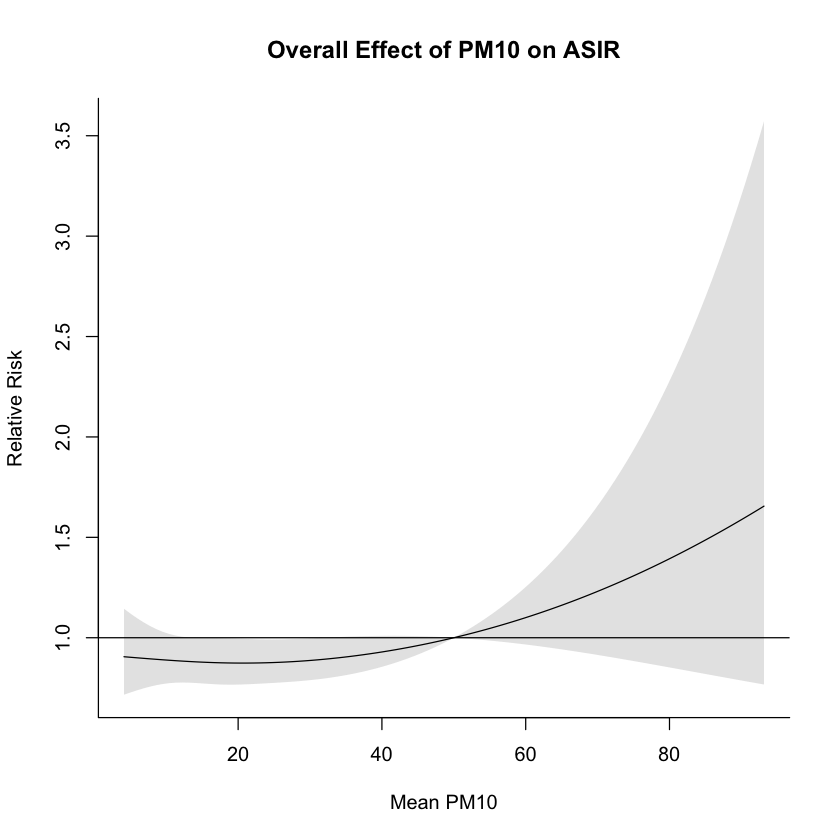

centering value unspecified. Automatically set to 50



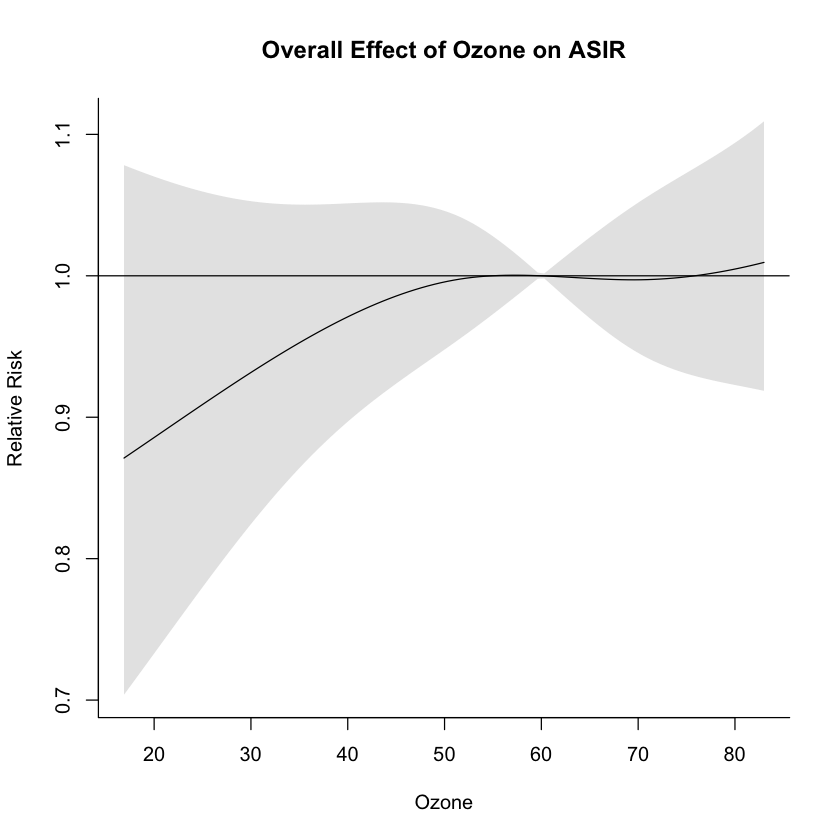

centering value unspecified. Automatically set to 25



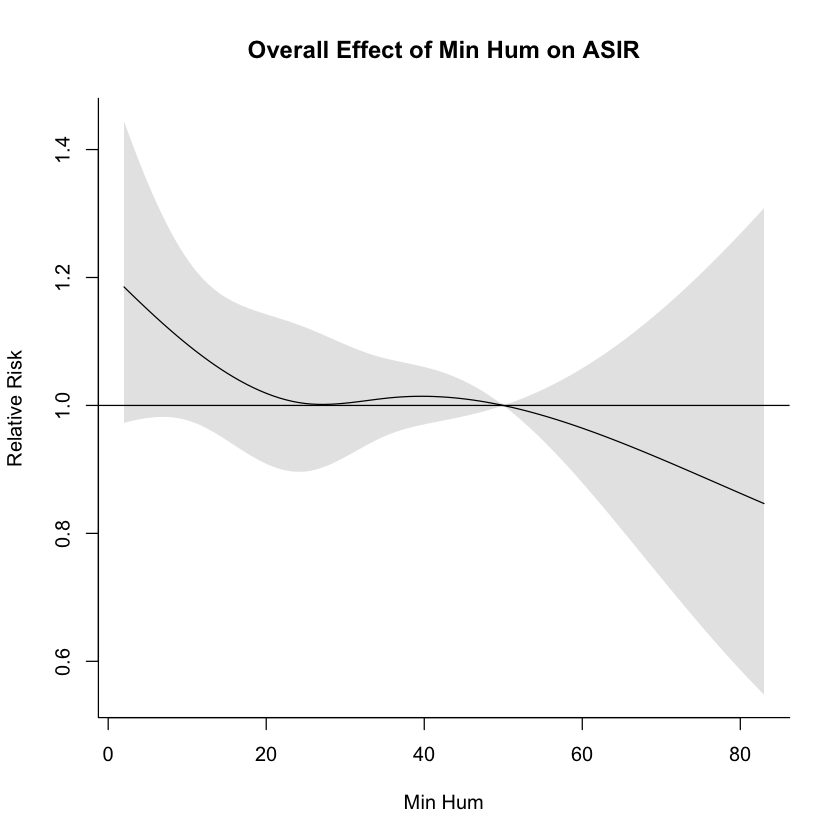

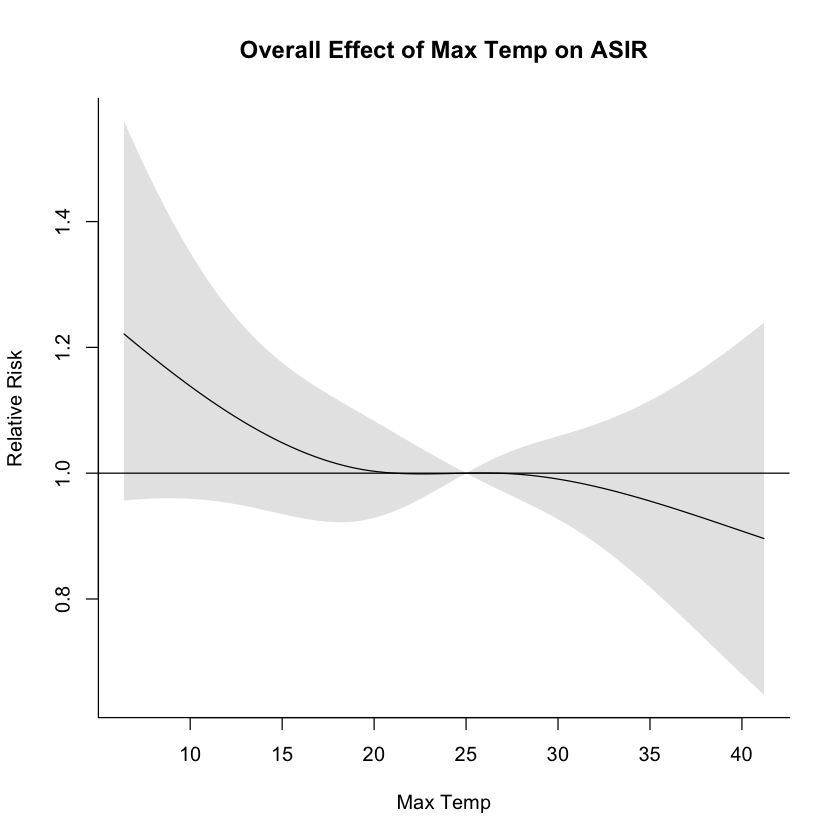

[1] "Dispersion parameter: 0.235613696196892"


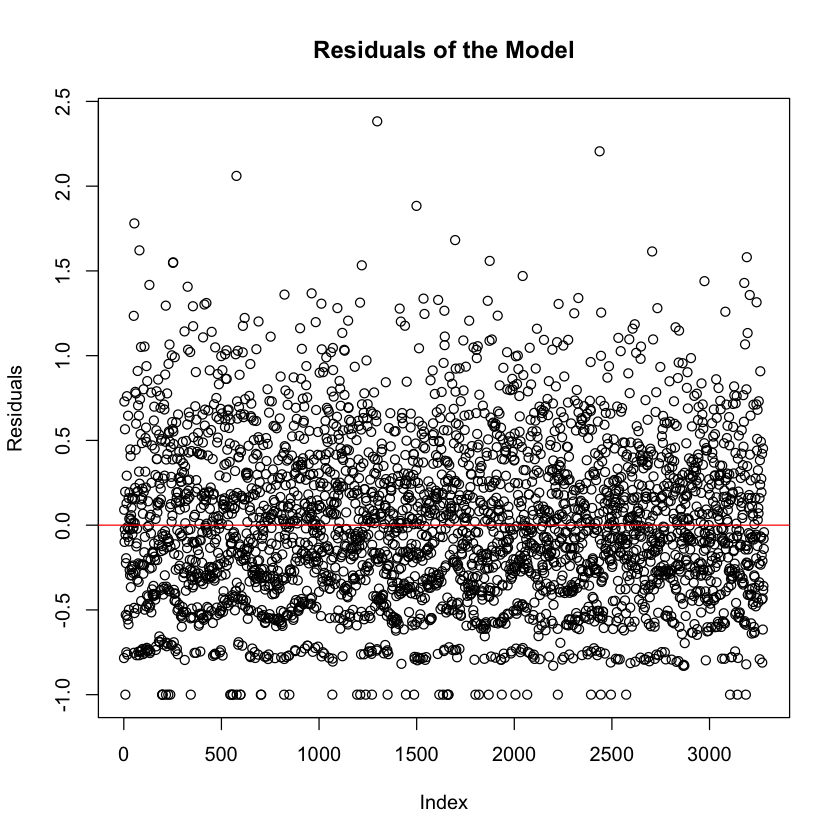

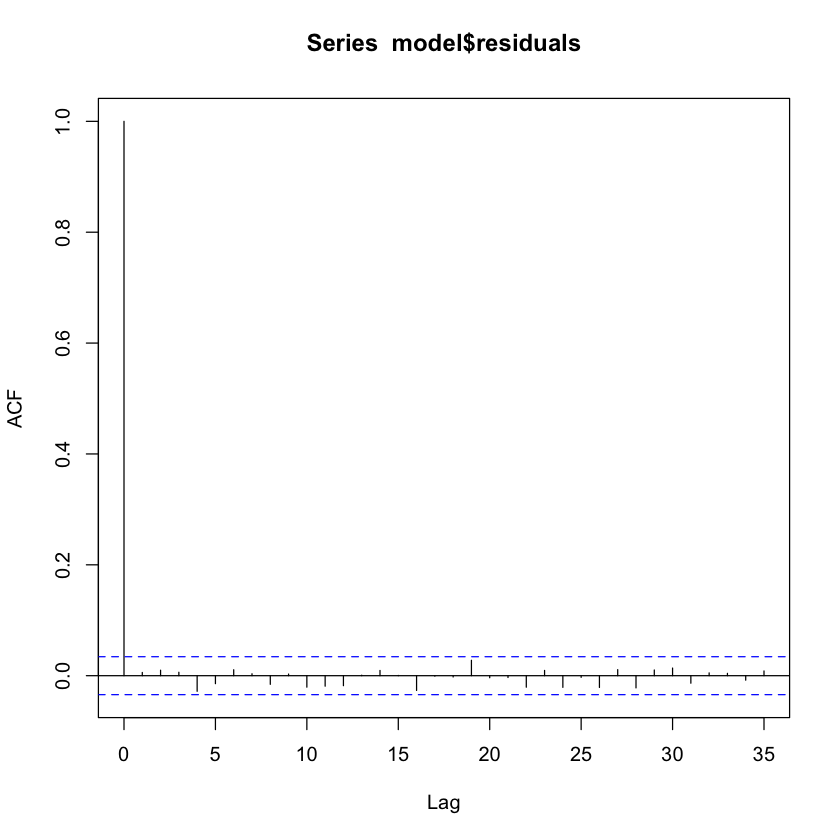

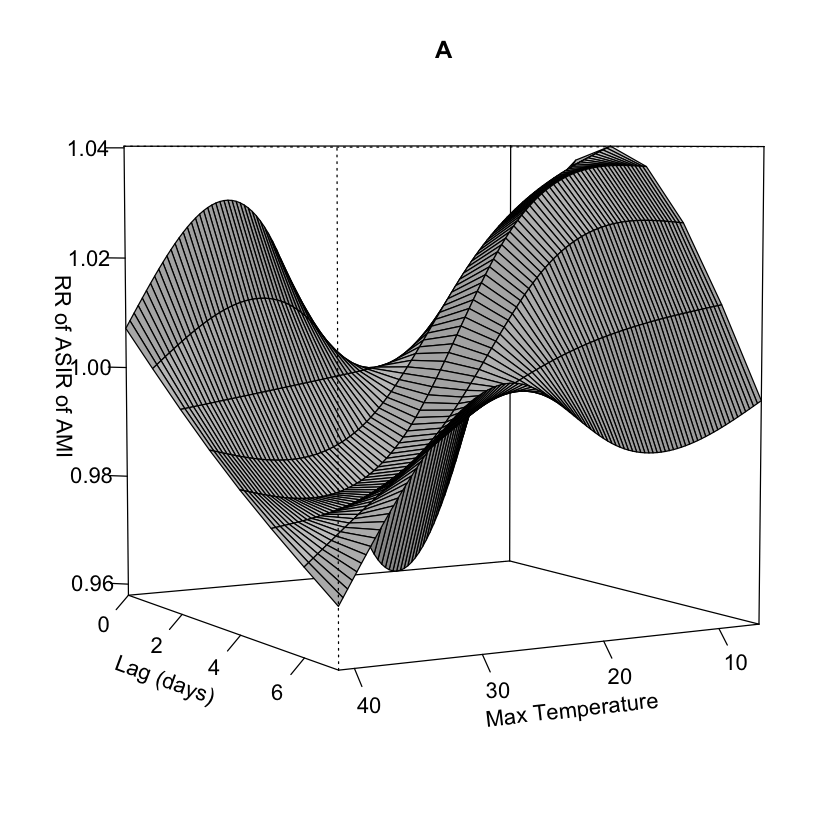

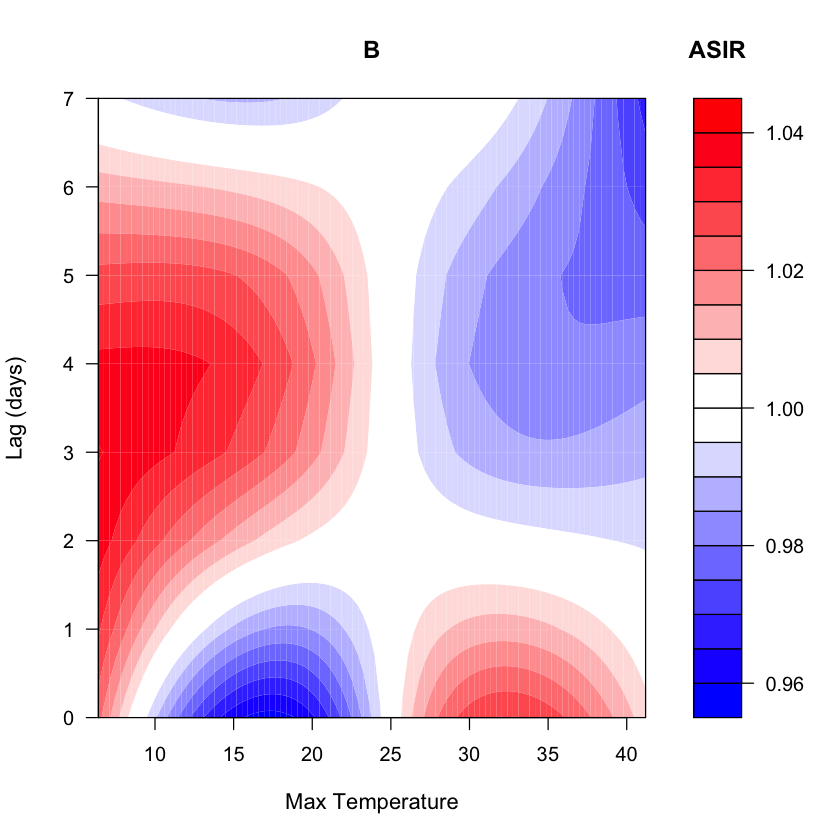

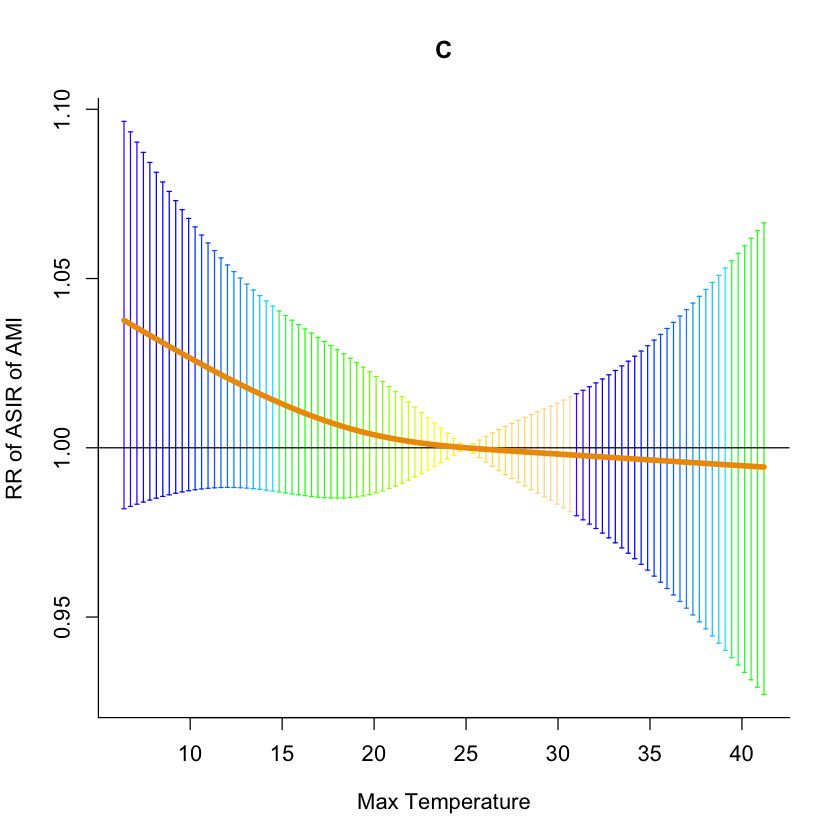

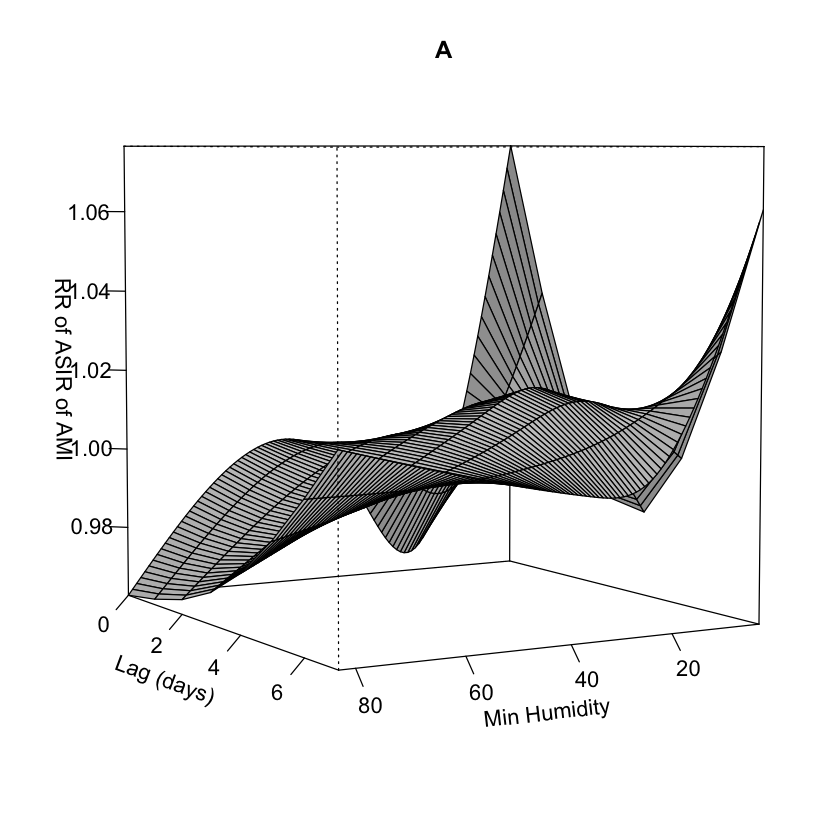

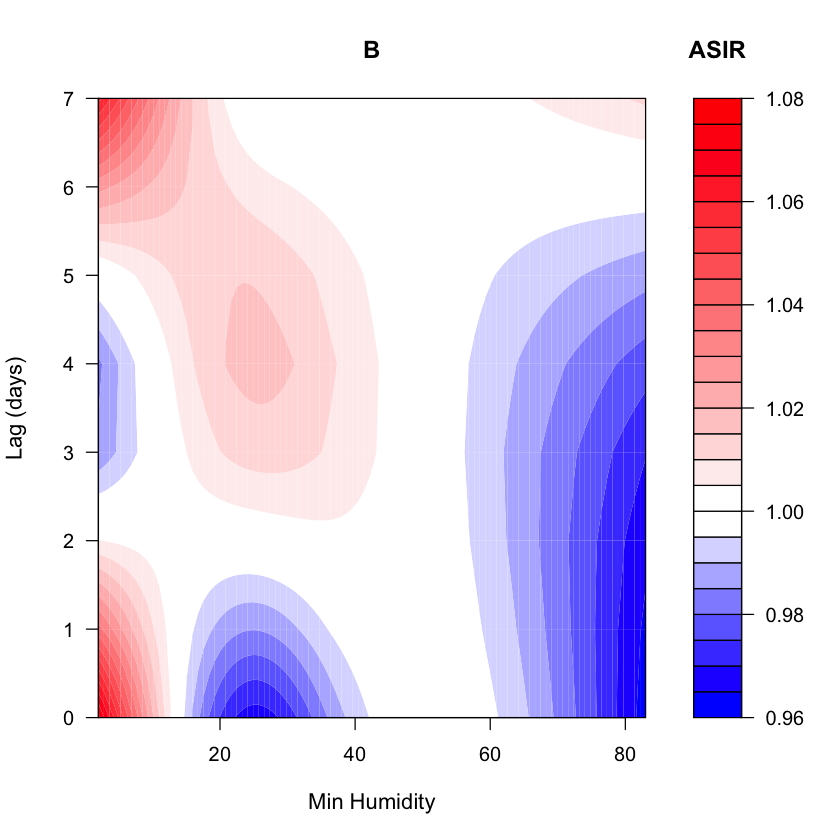

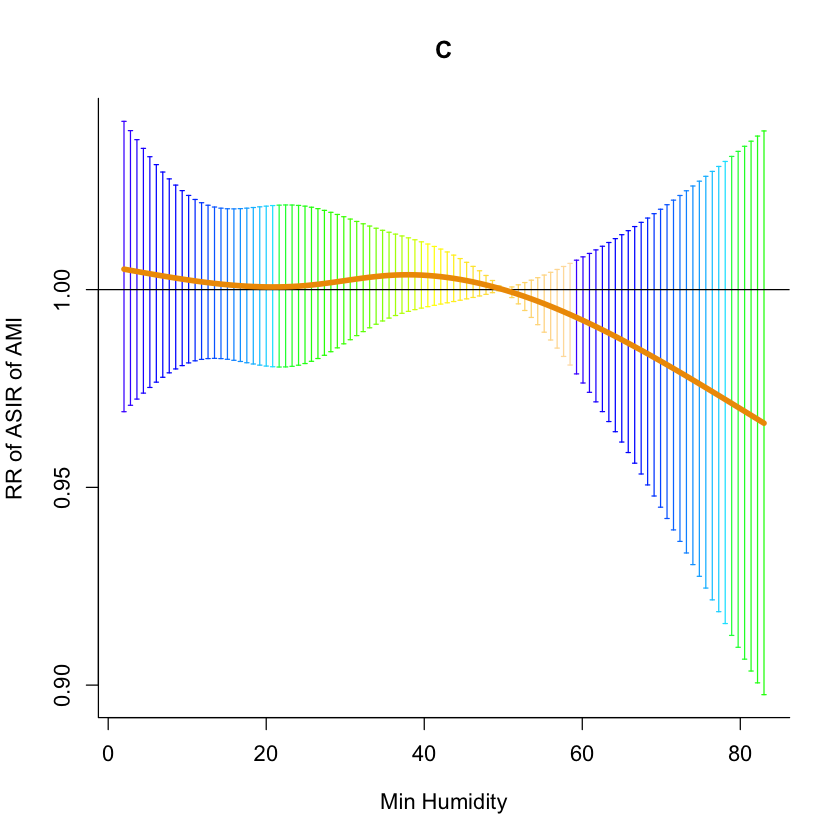

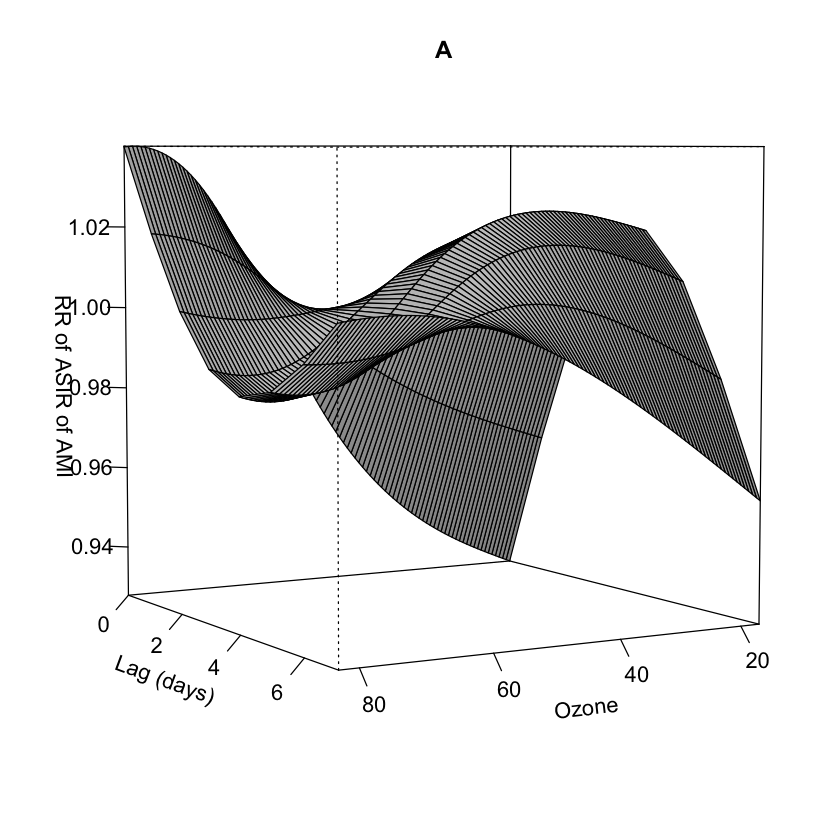

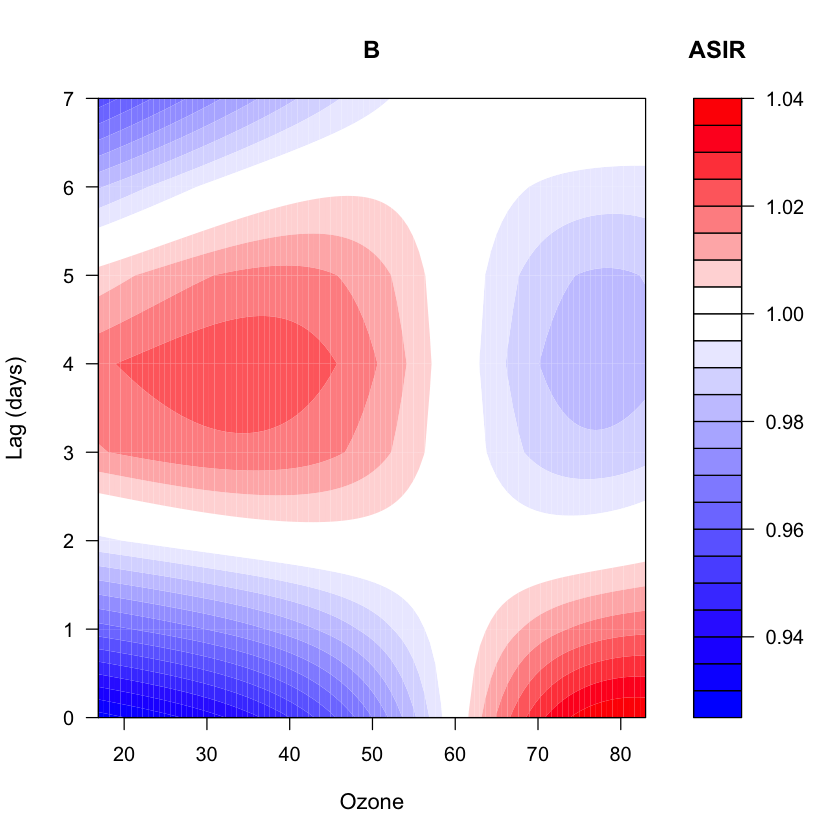

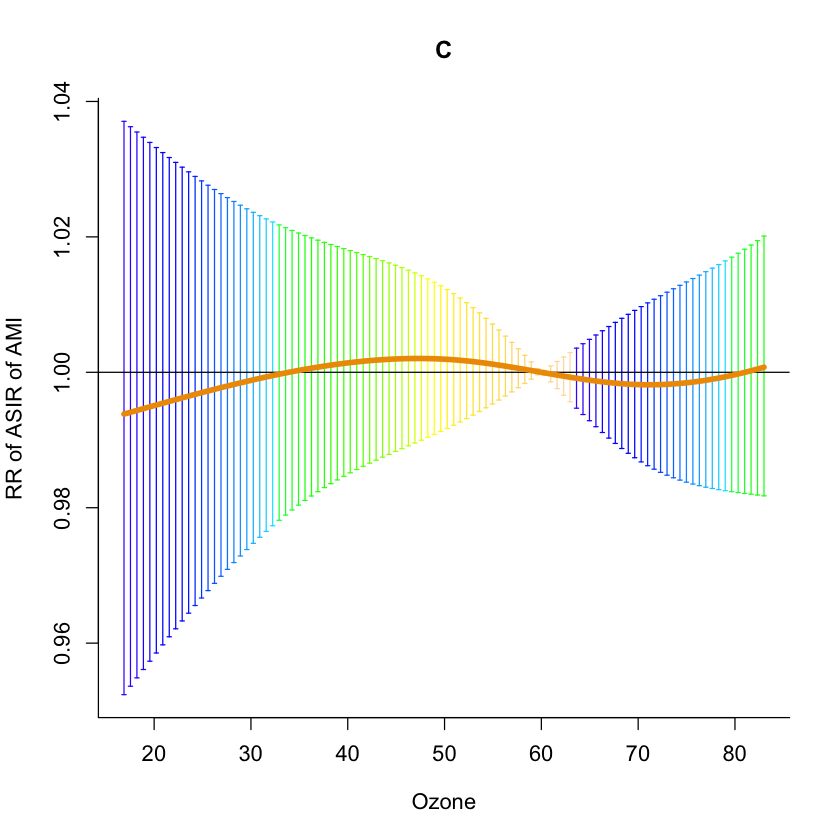

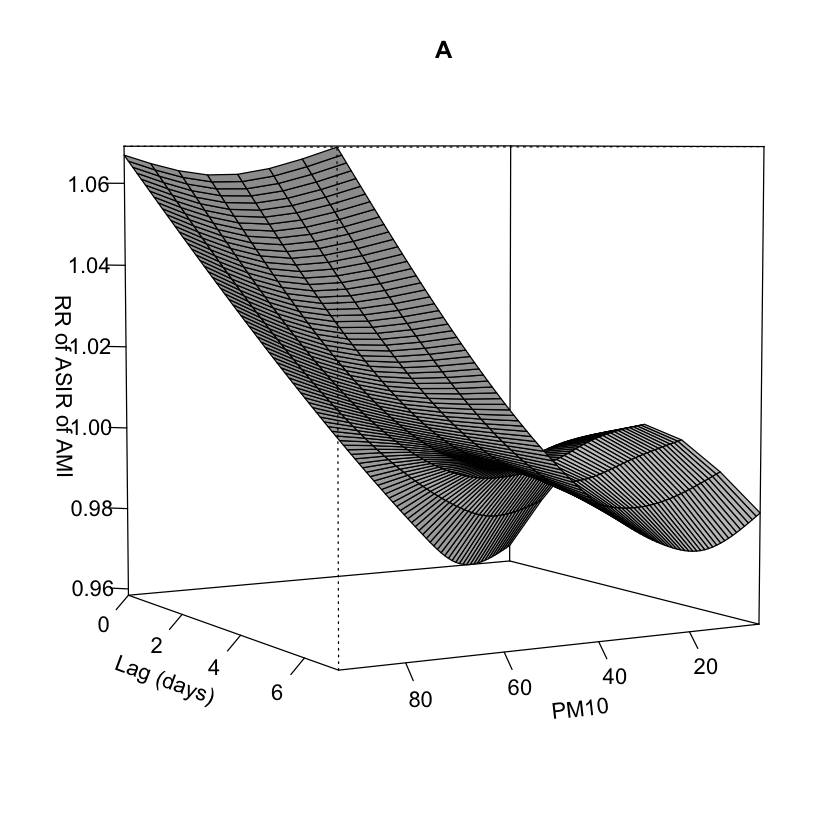

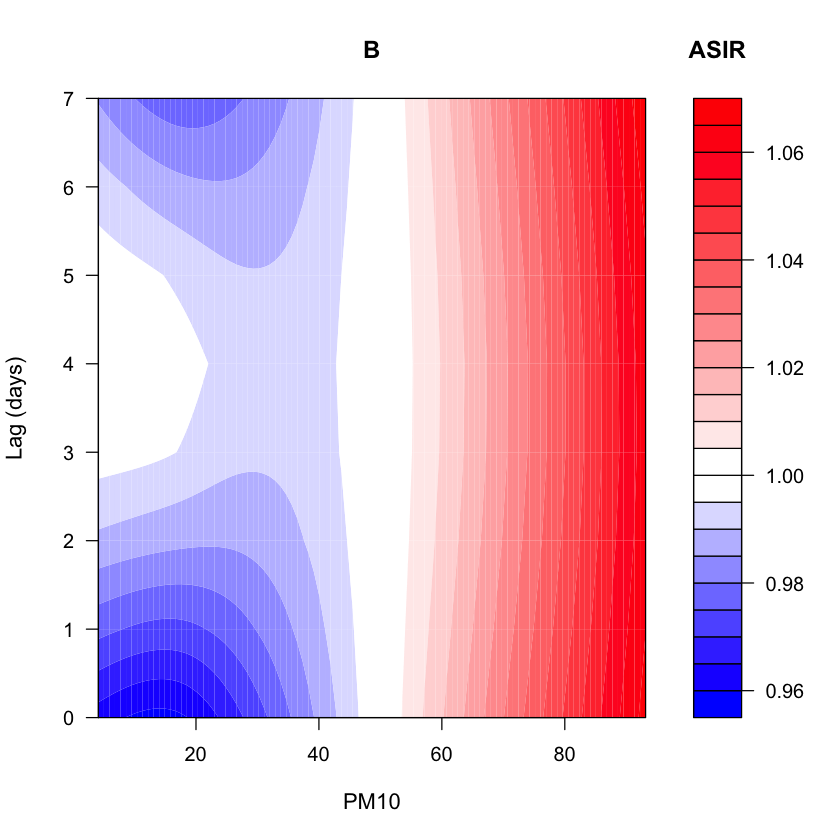

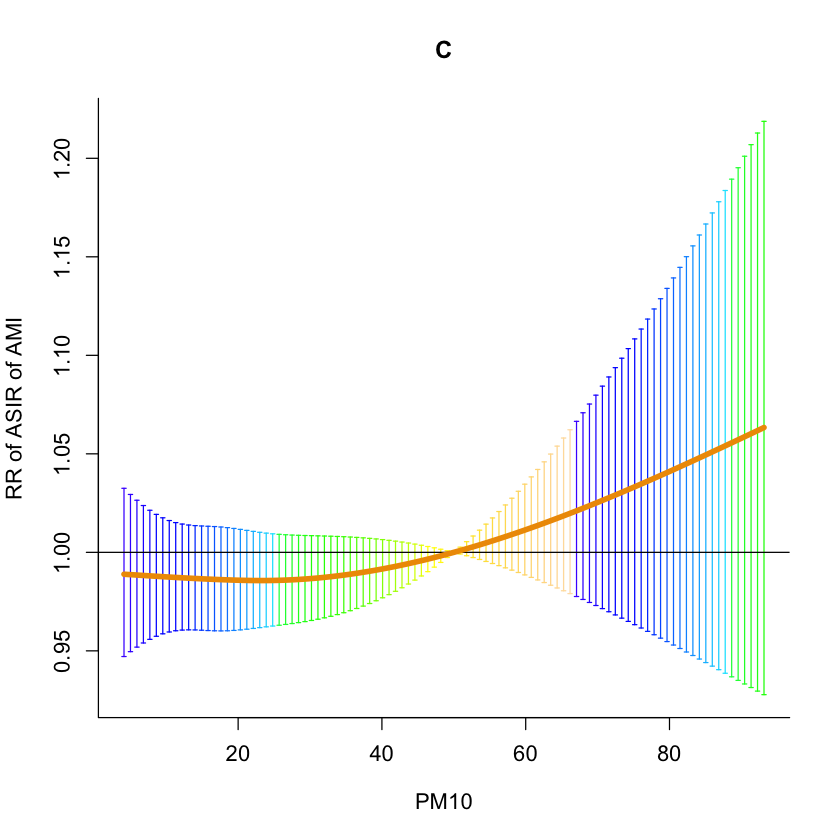

In [137]:
data <- read.csv("modelling_data/data.csv")
data <- data[c('at_code','date','min_hum','max_temp','min_temp','asir','is_holiday','dow','day','month','year','doy','season','mean_PM10','mean_O3')]
data = data[data$at_code=="AT01",]
data$date <- as.Date(data$date)

# # Scale the continuous predictors
# data$mean_PM10 <- scale(data$mean_PM10)
# data$min_hum <- scale(data$min_hum)
# data$max_temp <- scale(data$max_temp)
# data$min_temp <- scale(data$min_temp)
# data$mean_O3 <- scale(data$mean_O3)

# Create crossbasis for mean_PM10 and min_hum and ozone
cb_PM10 <- crossbasis(data$mean_PM10, lag=7, 
                      argvar=list(fun="ns", df=3), 
                      arglag=list(fun="ns", df=3))

cb_min_hum <- crossbasis(data$min_hum, lag=7, 
                         argvar=list(fun="ns", df=3), 
                         arglag=list(fun="ns", df=3))

cb_O3 <- crossbasis(data$mean_O3, lag=7, 
                         argvar=list(fun="ns", df=3), 
                         arglag=list(fun="ns", df=3))

cb_max_temp <- crossbasis(data$max_temp, lag=7, 
                    argvar=list(fun="ns", df=3), 
                    arglag=list(fun="ns", df=3))

# Fit DLNM including min_hum
model <- glm(asir ~ cb_PM10 + cb_min_hum + cb_O3 + cb_max_temp + is_holiday + dow + ns(day, df=4) + ns(month, df=6) + ns(year, df=8), 
             data = data, family = quasipoisson)

# model <- glm(asir ~ cb_PM10 + cb_min_hum + cb_O3 + cb_max_temp, 
#              data = data, family = quasipoisson)


# Summary of the model
summary(model)
# Create crosspred object for visualization of PM10
pred_PM10 <- crosspred(cb_PM10, model, at=seq(min(data$mean_PM10), max(data$mean_PM10), length=100))
# Plot overall cumulative effect
plot(pred_PM10, "overall", xlab="Mean PM10", ylab="Relative Risk", main="Overall Effect of PM10 on ASIR")

# Create crosspred object for visualization of ozone
pred_ozone <- crosspred(cb_O3, model, at=seq(min(data$mean_O3), max(data$min_hum), length=100))
# Plot overall cumulative effect
plot(pred_ozone, "overall", xlab="Ozone", ylab="Relative Risk", main="Overall Effect of Ozone on ASIR")

# Create crosspred object for visualization of min_hum
pred_min_hum <- crosspred(cb_min_hum, model, at=seq(min(data$min_hum), max(data$min_hum), length=100))
# Plot overall cumulative effect
plot(pred_min_hum, "overall", xlab="Min Hum", ylab="Relative Risk", main="Overall Effect of Min Hum on ASIR")

# Create crosspred object for visualization of max_temp
pred_max_temp <- crosspred(cb_max_temp, model, at=seq(min(data$max_temp), max(data$max_temp), length=100))
# Plot overall cumulative effect
plot(pred_max_temp, "overall", xlab="Max Temp", ylab="Relative Risk", main="Overall Effect of Max Temp on ASIR")

plot(model$residuals, main="Residuals of the Model", ylab="Residuals", xlab="Index")
abline(h=0, col="red")

dispersion <- sum(residuals(model, type="pearson")^2) / model$df.residual
print(paste("Dispersion parameter:", dispersion))

#qqnorm(model$residuals)
#qqline(model$residuals, col="red")

acf(model$residuals)

# 3D, contour, and curve plots for max temperature
plot(pred_max_temp, xlab="Max Temperature", ylab="Lag (days)", zlab="RR of ASIR of AMI", theta=150, phi=5, lphi=100, cex.lab=1.1, cex.axis=1.1, col="gray80",main="A")
plot(pred_max_temp, "contour", key.title=title("ASIR"), plot.title=title("B", xlab ="Max Temperature", ylab = "Lag (days)", cex.lab=1.1, cex.axis=1.1))
plot(pred_max_temp, "slices", xlab="Max Temperature", lag=c(2), col="orange2", ci.arg=list(col=topo.colors(70, alpha = 1)), ci.level=0.95, ci='b', lwd=4.5, ylab="RR of ASIR of AMI", cex.lab=1.1, cex.axis=1.1,main="C")

# 3D, contour, and curve plots for min humidity
plot(pred_min_hum, xlab="Min Humidity", ylab="Lag (days)", zlab="RR of ASIR of AMI", theta=150, phi=5, lphi=100, cex.lab=1.1, cex.axis=1.1, col="gray80",main="A")
plot(pred_min_hum, "contour", key.title=title("ASIR"), plot.title=title("B", xlab ="Min Humidity", ylab = "Lag (days)", cex.lab=1.1, cex.axis=1.1))
plot(pred_min_hum, "slices", xlab="Min Humidity", lag=c(2), col="orange2", ci.arg=list(col=topo.colors(70, alpha = 1)), ci.level=0.95, ci='b', lwd=4.5, ylab="RR of ASIR of AMI", cex.lab=1.1, cex.axis=1.1,main="C")

# 3D, contour, and curve plots for ozone
plot(pred_ozone, xlab="Ozone", ylab="Lag (days)", zlab="RR of ASIR of AMI", theta=150, phi=5, lphi=100, cex.lab=1.1, cex.axis=1.1, col="gray80",main="A")
plot(pred_ozone, "contour", key.title=title("ASIR"), plot.title=title("B", xlab ="Ozone", ylab = "Lag (days)", cex.lab=1.1, cex.axis=1.1))
plot(pred_ozone, "slices", xlab="Ozone", lag=c(2), col="orange2", ci.arg=list(col=topo.colors(70, alpha = 1)), ci.level=0.95, ci='b', lwd=4.5, ylab="RR of ASIR of AMI", cex.lab=1.1, cex.axis=1.1,main="C")

# 3D, contour, and curve plots for rainfall
plot(pred_PM10, xlab="PM10", ylab="Lag (days)", zlab="RR of ASIR of AMI", theta=150, phi=5, lphi=100, cex.lab=1.1, cex.axis=1.1, col="gray80",main="A")
plot(pred_PM10, "contour", key.title=title("ASIR"), plot.title=title("B", xlab ="PM10", ylab = "Lag (days)", cex.lab=1.1, cex.axis=1.1))
plot(pred_PM10, "slices", xlab="PM10", lag=c(2), col="orange2", ci.arg=list(col=topo.colors(70, alpha = 1)), ci.level=0.95, ci='b', lwd=4.5, ylab="RR of ASIR of AMI", cex.lab=1.1, cex.axis=1.1,main="C")

